<a href="https://colab.research.google.com/github/emanbuc/ML-GAN/blob/main/Test_Pytorch_Complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch --upgrade
!pip install pytorch-complex
!pip install fastai==2.5.3 -q

     |████████████████████████████████| 750.6 MB 9.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.3 requires torch==1.10.2, but you have torch 1.11.0 which is incompatible.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.10.2 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.10.2 which is incompatible.


In [2]:
import  torchcomplex.nn as nnc
import torch

import math
import matplotlib.pyplot as plt

In [3]:
# This discriminator is an MLP neural network 
class Discriminator(nnc.Module):
    def __init__(self):
        super().__init__()
        self.model = nnc.Sequential(
            #The input is two-dimensional, and the first hidden layer is composed 
            # of 256 neurons with ReLU activation.
            nnc.Linear(2, 256),
            nnc.CReLU(),
            # use dropout after hidden layer to avoid overfitting.
            nnc.Dropout(0.3),
            nnc.Linear(256, 128),
            nnc.CReLU(),
            nnc.Dropout(0.3),
            nnc.Linear(128, 64),
            nnc.CReLU(),
            nnc.Dropout(0.3),
            nnc.Linear(64, 1),
            # The output is composed of a single neuron with sigmoidal activation
            # to represent a probability.
            nnc.Sigmoid(),
        )

     # .forward() to describe how the output of the model is calculated
    def forward(self, x):
        output = self.model(x)
        return output

# instantiate a Discriminator object
discriminator = Discriminator()

In [4]:
class Generator(nnc.Module):
    def __init__(self):
        super().__init__()
        self.model = nnc.Sequential(
            nnc.Linear(2, 16),
            nnc.CReLU(),
            nnc.Linear(16, 32),
            nnc.CReLU(),
            nnc.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [5]:
lr = 0.001
num_epochs = 300

# The binary cross-entropy function is a suitable loss function for training the discriminator 
# because it considers a binary classification task. 
# It’s also suitable for training the generator since it feeds its output to the discriminator,
# which provides a binary observable output.
#loss_function = torch.nn.BCELoss()
# ne serve una che support ai numeri complessi
loss_function = torch.nn.L1Loss()

In [6]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## Load Training Data from EIS Dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
import sys

In [8]:
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell
external_python_file_path="'/.'"
sys.path.append(external_python_file_path)


from eb_ml_colab_utils import get_root_path,copy_model_to_google_drive
from eb_ml_battery_lib import load_soc_dataset,generate_image_files_from_eis
from eb_ml_utils import save_model_weights,build_data_loader,build_and_train_learner,score_model

In [9]:
#configuration dictionary
config ={}

# Root working folder (local or Google Drive)
# config['ROOT_DIR'] = get_root_path("batterie")
config['ROOT_DIR'] = get_root_path("batterie")  

# Folder with dataset in CSV format
#config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets"
config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets/EIS-vs-SOC-2022"

# List of SoC level into dataset
#config['soc_list']=['100','090','080','070','060','050','040','030','020','010']
config['soc_list']=['100','090','080','070','060','050','040','030','020','010']


# Folder to store trained model
#config['MODELS_DIR'] = config['ROOT_DIR']+"/models"
config['MODELS_DIR'] = config['ROOT_DIR']+"/models"

Running on COLAB
Mounted at /gdrive


In [10]:
# Data acquition file to load from dateset folder
# EIS Dataset https://data.mendeley.com/datasets/ch3sydbbrg/2
frequency_list=[ 0.05, 0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]
battery_list=[1,2,3,4,5,7,8,9,10,11,12] # Data acquitions 6,13 to be used for TEST]
dataset,feature_col_names=load_soc_dataset(battery_list,config["soc_list"],config['DATASETS_DIR'])

In [11]:
feature_col_names

['Z_f0',
 'Z_f1',
 'Z_f2',
 'Z_f3',
 'Z_f4',
 'Z_f5',
 'Z_f6',
 'Z_f7',
 'Z_f8',
 'Z_f9',
 'Z_f10',
 'Z_f11',
 'Z_f12',
 'Z_f13']

In [12]:
soc_10_training=dataset.query('SOC== "010"')[feature_col_names]
soc_10_training

,Z_f0,Z_f1,Z_f2,Z_f3,Z_f4,Z_f5,Z_f6,Z_f7,Z_f8,Z_f9,Z_f10,Z_f11,Z_f12,Z_f13
010,0.079771-0.005349j,0.077740-0.004683j,0.076173-0.003523j,0.075399-0.003229j,0.073304-0.003548j,0.071919-0.004337j,0.069978-0.004903j,0.066565-0.005511j,0.063821-0.005493j,0.061411-0.005366j,0.057958-0.005174j,0.055633-0.004818j,0.053745-0.004118j,0.051447-0.003001j
010,0.078894-0.004942j,0.077379-0.003965j,0.076076-0.003162j,0.075439-0.002577j,0.073901-0.002919j,0.072642-0.003744j,0.070944-0.004596j,0.067612-0.005322j,0.064984-0.005585j,0.062448-0.005382j,0.059086-0.005205j,0.056763-0.004722j,0.054563-0.004204j,0.052500-0.002999j
010,0.074923-0.004870j,0.073477-0.003759j,0.072532-0.002710j,0.071758-0.002316j,0.070510-0.002377j,0.069565-0.003037j,0.068364-0.003993j,0.065447-0.005366j,0.062517-0.006183j,0.059429-0.006285j,0.055555-0.005599j,0.053129-0.004991j,0.050902-0.004287j,0.048653-0.003007j
010,0.074411-0.004880j,0.072787-0.003883j,0.071541-0.003067j,0.070933-0.002429j,0.069589-0.002628j,0.068560-0.003292j,0.067239-0.003997j,0.064362-0.005227j,0.061435-0.005945j,0.058558-0.005913j,0.054922-0.005389j,0.052485-0.004896j,0.050414-0.004192j,0.048036-0.003069j
010,0.078197-0.004944j,0.076708-0.003921j,0.075516-0.002831j,0.074972-0.002334j,0.073589-0.002613j,0.072889-0.003227j,0.071461-0.004222j,0.068578-0.005554j,0.065428-0.006255j,0.062342-0.006436j,0.058299-0.005866j,0.055709-0.005264j,0.053496-0.004382j,0.051192-0.003051j
010,0.073499-0.004352j,0.071975-0.003375j,0.071127-0.002276j,0.070579-0.001976j,0.069628-0.001913j,0.069061-0.002316j,0.068349-0.002973j,0.066075-0.004737j,0.063371-0.005850j,0.060204-0.006134j,0.056277-0.005871j,0.053678-0.004992j,0.051553-0.004286j,0.049336-0.002925j
010,0.075002-0.004450j,0.073594-0.003316j,0.072728-0.002386j,0.072421-0.002074j,0.071293-0.002048j,0.070492-0.002500j,0.069626-0.003237j,0.067319-0.004893j,0.064682-0.005829j,0.061710-0.006009j,0.057768-0.005385j,0.055370-0.004826j,0.053423-0.003888j,0.051324-0.002779j
010,0.079897-0.004582j,0.078391-0.003490j,0.077319-0.002565j,0.076870-0.001969j,0.075815-0.002046j,0.075152-0.002592j,0.074303-0.003259j,0.071812-0.004872j,0.069079-0.005790j,0.065966-0.006023j,0.062122-0.005708j,0.059560-0.004794j,0.057592-0.003948j,0.055631-0.002843j
010,0.077036-0.004560j,0.075534-0.003552j,0.074379-0.002565j,0.073773-0.002133j,0.072797-0.002270j,0.072098-0.002704j,0.071250-0.003512j,0.068566-0.005268j,0.065698-0.006345j,0.062095-0.006770j,0.057652-0.006236j,0.054922-0.005423j,0.052739-0.004440j,0.050409-0.003261j
010,0.097612-0.004647j,0.095967-0.003856j,0.094797-0.002671j,0.094201-0.002246j,0.093193-0.002260j,0.092317-0.002724j,0.091361-0.003504j,0.088793-0.004872j,0.086085-0.005751j,0.083177-0.006003j,0.079377-0.005685j,0.076842-0.005000j,0.074681-0.004194j,0.072418-0.002935j


In [13]:
total_EIS_num = len(soc_10_training)
n_frequency =len(frequency_list)
train_data_length = total_EIS_num * n_frequency  #14*11

# initialize train_data, a tensor with dimensions of <train_data_length> rows and 2 columns, all containing zeros. 
# Note: A tensor is a multidimensional array similar to a NumPy array.
train_data = torch.zeros((train_data_length,2),dtype=torch.cfloat)

In [14]:
from operator import mod

for i  in range(0,train_data_length):
  f_index = i % 14
  row_index = i // 14
  # the first column of train_data store the frequency values
  train_data[i, 0] = frequency_list[f_index]
  # the second column of the tensor  Z(f)
  train_data[i, 1] = tensor(soc_10_training)[row_index,f_index]

In [15]:
# init tensor of labels, which are required by PyTorch’s data loader. 
# Since GANs make use of unsupervised learning techniques, the labels can be anything.
train_labels = torch.zeros(train_data_length)

# create train_set as a list of tuples, with each row of train_data and train_labels represented in each tuple 
# this is the format expected by PyTorch’s data loader.
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

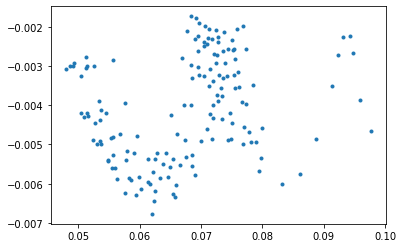

In [22]:
plt.plot(np.real(train_data[:, 1]), np.imag(train_data[:, 1]), ".")

## Training

In [16]:
# create a PyTorch data loader called train_loader.
# Data Loader will shuffle the data from train_set and return batches of <batch_size> samples 
# to be used to train the neural networks.

batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

In [17]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1),dtype=torch.cfloat)
        latent_space_samples = torch.randn((batch_size, 2),dtype=torch.cfloat)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1),dtype=torch.cfloat)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2),dtype=torch.cfloat)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()


In [ ]:
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [24]:
latent_space_samples = torch.randn(100, 2,dtype=torch.cfloat)
generated_samples = generator(latent_space_samples)

In [30]:
generator(latent_space_samples)

tensor([[nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [n

In [28]:
latent_space_samples

tensor([[ 5.9374e-02+3.3002e-02j,  1.1338e-01+7.0591e-05j],
        [ 1.2707e+00+5.4934e-01j,  8.3832e-01-9.9213e-01j],
        [-2.5704e-01+3.5390e-02j, -1.9093e-01+1.7553e-01j],
        [-5.7357e-01+1.1355e+00j, -9.5251e-01+9.8376e-01j],
        [ 2.5741e-01+6.7453e-01j, -1.4936e+00-2.3991e-01j],
        [-9.1279e-02-3.4159e-01j,  1.1577e+00+6.6517e-01j],
        [ 9.7756e-01-4.7562e-01j,  2.4989e-01+1.7386e-01j],
        [-2.0137e-01-4.2738e-01j, -1.1866e+00+2.6014e-01j],
        [-1.1717e+00+2.3350e-01j, -6.3544e-01+1.2732e+00j],
        [-7.7418e-01-1.8462e-02j, -4.8653e-02-4.6823e-01j],
        [ 5.8409e-01+5.8234e-01j,  1.1352e+00-6.2812e-04j],
        [ 1.1030e+00+7.2447e-02j,  1.0657e-01-2.8100e-01j],
        [-1.4806e+00-5.9015e-01j,  5.1509e-02-2.0712e-01j],
        [-5.2135e-01+9.4070e-01j,  7.4988e-02-3.9318e-01j],
        [ 1.1874e+00-3.2887e-01j, -3.4695e-01+3.9471e-01j],
        [ 5.9014e-01+4.7772e-01j, -5.9292e-01-1.4757e+00j],
        [ 1.2999e+00-1.4615e-01j,  6.166

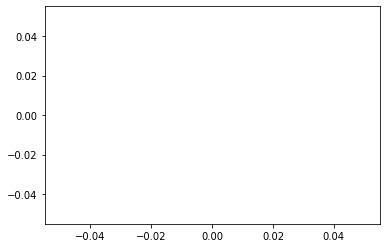

In [26]:
generated_samples = generated_samples.detach()
plt.plot(np.real(generated_samples[:, 1]), np.imag(generated_samples[:, 1]), ".")

In [29]:
generated_samples

tensor([[nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [n